# Spettro del Rubino

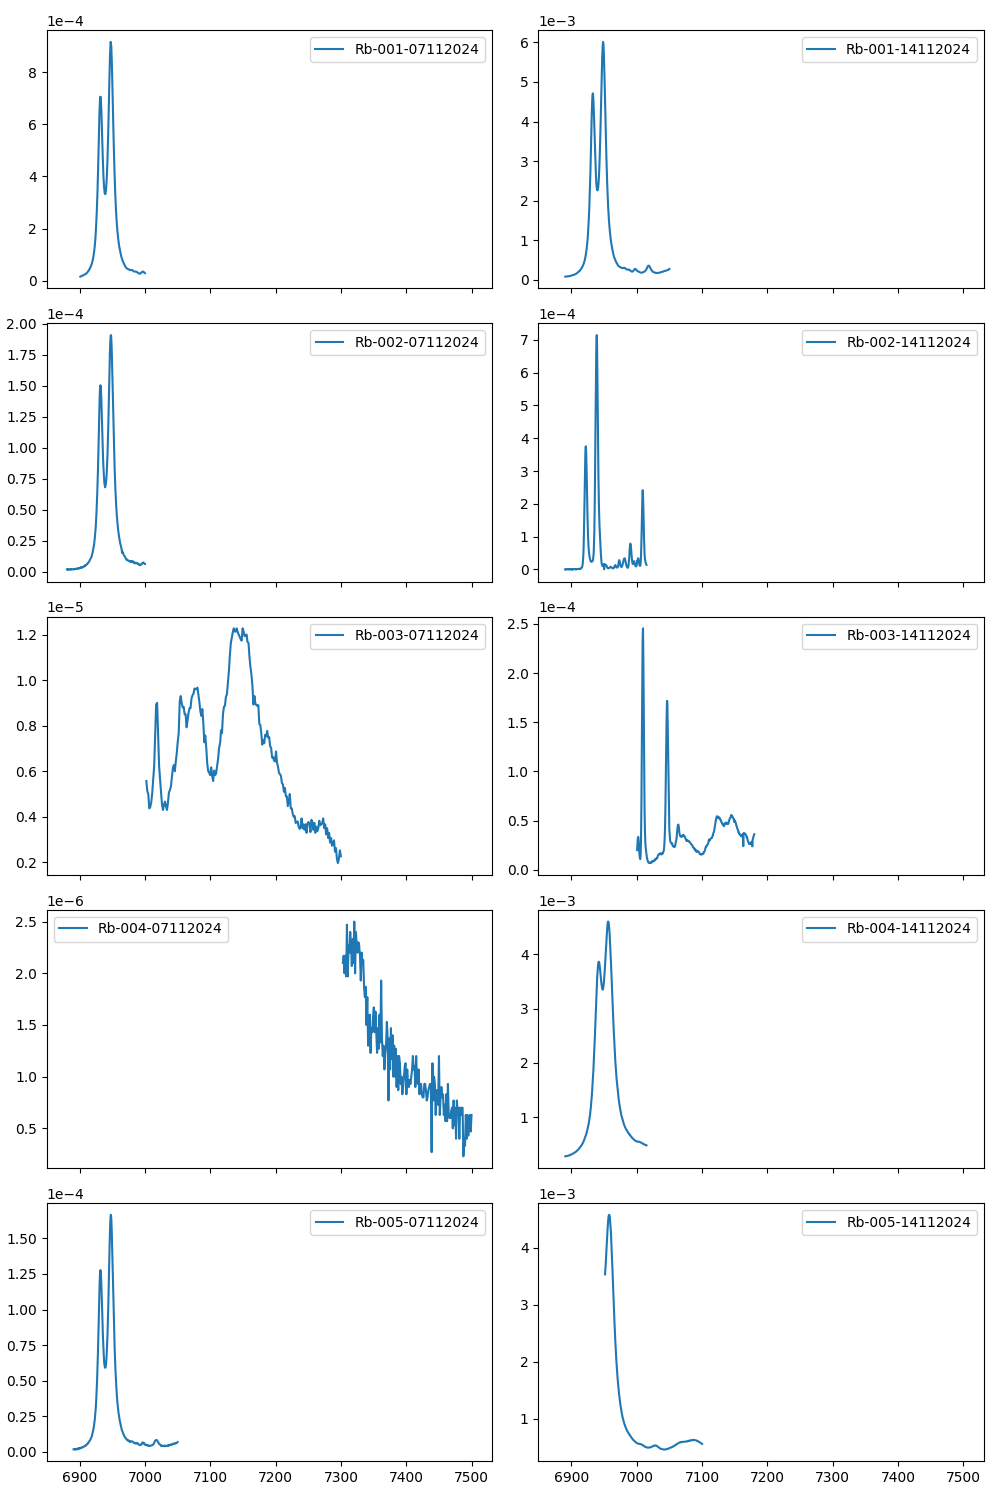

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from modules import utils
import pandas as pd
import ast
import scipy as sp
from matplotlib import cm
%matplotlib widget

plt.close('all')

# Load data
files = utils.getFiles('Raw_Data\\Rubidium_Spectrum')
files = [file for file in files if file.name.find('Rb_') != -1]
df = pd.DataFrame([utils.file_to_series(file) for file in files])

# sort it
df.sort_values('id', inplace=True)
df.sort_values('date', inplace=True)
df.reset_index(drop=True, inplace=True)

# A quick look at the data
fig, axs = plt.subplots(5, 2, sharex=True, figsize=(10, 15), layout='tight')
for i, row in df.iterrows():
    meta = ast.literal_eval(row['meta'])
    label = "-".join([meta.get(key) for key in ['type', 'id', 'date',]])
    axs[ i % 5, int(i / 5)].plot(row['wl'], row['mean'], label=label)
    
for ax in axs.flat:
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) 
    ax.legend()

In [79]:
from ipywidgets import FloatRangeSlider, FloatLogSlider, AppLayout, interactive, VBox, Output
# 07-11-2024
batch = df[df['date'] == '07112024']

# generate the info table
info = batch['meta'].apply(ast.literal_eval).apply(pd.Series)
info = info[['type', 'id', 'date'] + [col for col in info.columns if col not in ['type', 'id', 'date']]]
info['start'] = batch['wl'].apply(lambda x: x[0])
info['stop'] = batch['wl'].apply(lambda x: x[-1])
info['step'] = batch['wl'].apply(lambda x: x[1] - x[0])
info['samples'] = batch['wl'].apply(len)

cm = plt.get_cmap('tab10')
with plt.ioff():
    fig, ax = plt.subplots(figsize=(8, 5))    
    

def find_peaks(prominence=6e-7, width=(1, 20)):
    '''This function will be turned into a widget'''
    ax.clear()
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    ax.set_yscale('log')

    results = {}
    
    for i, row in batch.iterrows():
        label = " ".join([row['type'], row['id']])
        ax.plot(row['wl'], row['mean'], label=label, color=cm(i))
        peaks, properties = sp.signal.find_peaks(row['mean'], prominence=prominence, width=width)
        if len(peaks) == 0:
            continue

        res_full = sp.signal.peak_widths(row['mean'], peaks, rel_height=.5)
        # HACK: for some reason res_full[1:] is treathed as a tuple
        y, xmin, xmax = res_full[1:]
        xmin = info.loc[i, 'start'] + info.loc[i, 'step'] * xmin
        xmax = info.loc[i, 'start'] + info.loc[i, 'step'] * xmax
        
        # add the peaks to the results
        results[row['id']] = {'peaks': peaks}

        # draw the peaks
        ax.plot(row['wl'][peaks], row['mean'][peaks], "x", color=cm(i), alpha=0.5)
        ax.vlines(x=row['wl'][peaks], ymin=row['mean'][peaks] - properties["prominences"],
                    ymax = row['mean'][peaks], color = cm(i), alpha=0.5)  
        ax.hlines(y=y, xmin=xmin, xmax=xmax, color=cm(i), alpha=0.5)
    
    ax.legend()
    return results


# widget to find peaks
prominance = FloatLogSlider(value=1.22e-6, base=10, min=-8, max=-2, step=0.01, readout_format='.3e', continuous_update=False)
width = FloatRangeSlider(value=(1, 20), min=0, max=40, step=1, readout_format='d', continuous_update=False)
w = interactive(find_peaks, prominence=prominance, width=width, continuous_update=False)
out = Output()
result = Output()
with out:
    display(info)
with result:
    display(w.result)

AppLayout(
    center=fig.canvas,
    right_sidebar=VBox([w, result]),
    footer = out,
    pane_widths=[0, 2, 1]
)

AppLayout(children=(Output(layout=Layout(grid_area='footer')), VBox(children=(interactive(children=(FloatLogSl…

99 99
199 199
249 249


C:\Users\alber\AppData\Local\Temp\ipykernel_8036\1367687713.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


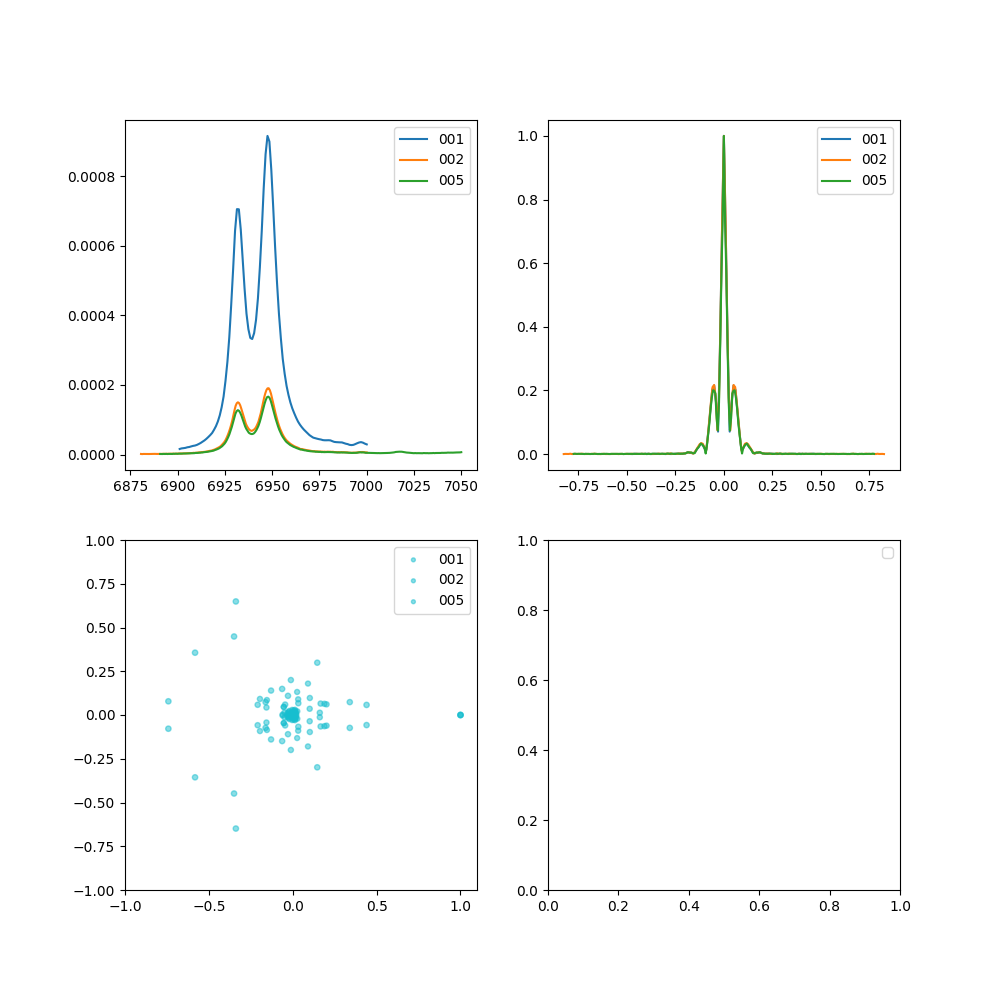

In [ ]:
from scipy.fft import rfft, irfft, fft, ifft, fftfreq, fftshift
from scipy.fft import fftn, ifftn

data = batch[batch['id'].isin(['001', '002', '005'])][['id', 'wl', 'mean']].reset_index(drop=True)
data['step'] = data['wl'].apply(lambda x: x[1] - x[0])
data['fft'] = data['mean'].apply(lambda x: fftshift(fft(x)))
data['freq'] = data.apply(lambda x: fftshift(fftfreq(x['wl'].size, d=x['step'])), axis=1)

fig, axs = plt.subplots(2,2 , figsize=(10, 10))
for i, row in data.iterrows():
    norm = max(np.abs(row['fft']))

    s = np.linspace(1, 15, len(row['fft']) // 2)
    s = np.concatenate([s, s[::-1]])

    if row['fft'].size % 2 == 1:
       s = np.append(s, 1)

    c = cm(s / max(s))

    print(s.size, row['fft'].size)

    axs[0,0].plot(row['wl'], row['mean'], label=row['id'])
    axs[0,1].plot(row['freq'], np.abs(row['fft']) / norm, label=row['id'])
    axs[1,0].scatter(row['fft'].real / norm, row['fft'].imag / norm, label=row['id'], marker='o', alpha=0.5, s=s, c=c)
   

axs[1,0].set_xlim(-1, 1.1)
axs[1,0].set_ylim(-1, 1)

for ax in axs.flat:
    ax.legend()  







ValueError: setting an array element with a sequence.

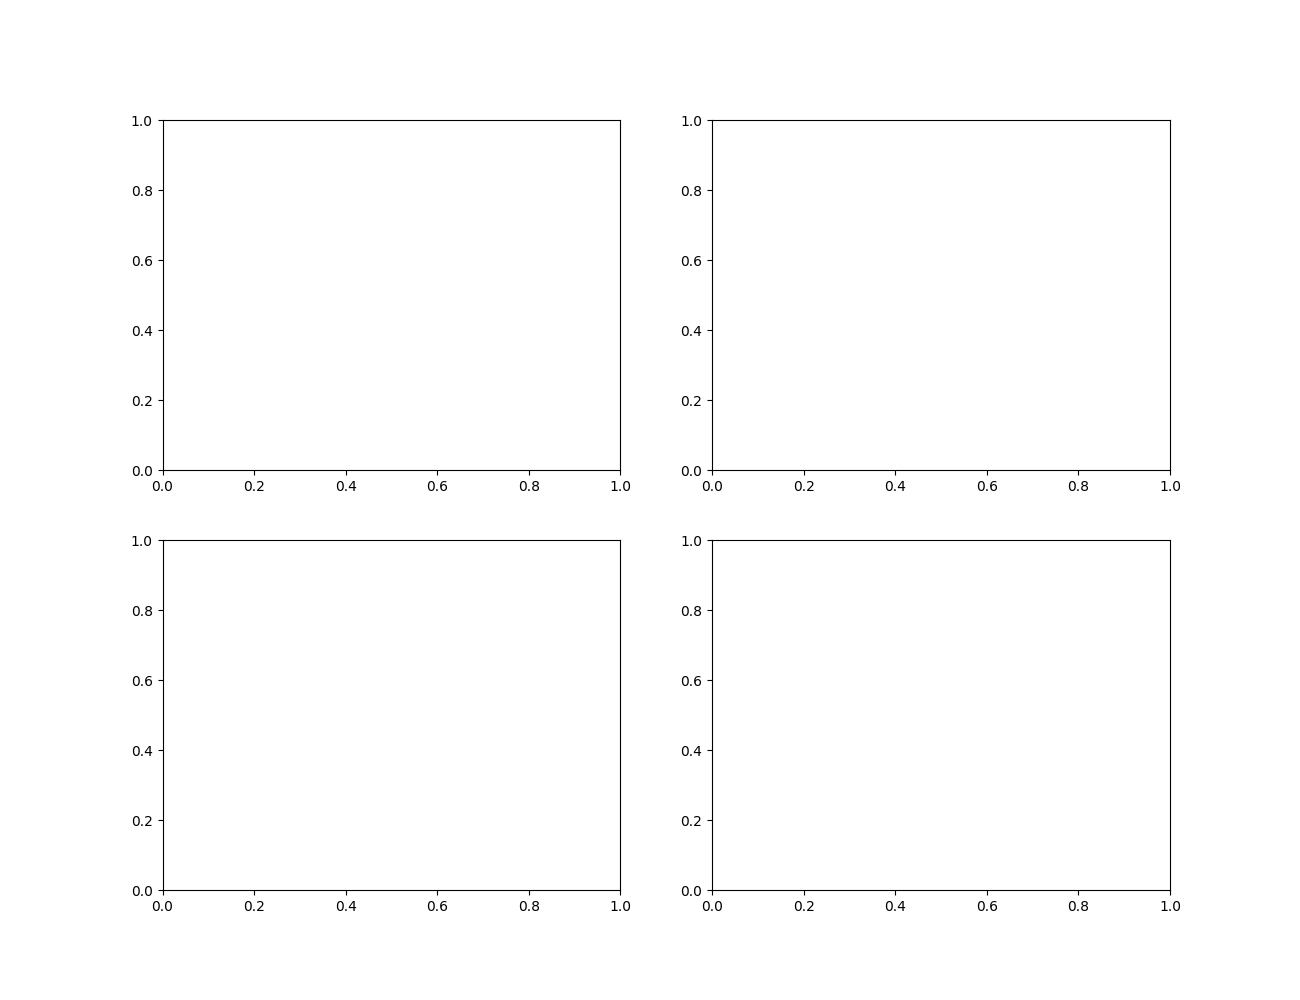

In [81]:
fig, axs = plt.subplots(2,2, figsize=(13, 10))
# Fourier transform
f = fftn(mean)

print(f)


axs[0,0].plot(ifft(f))
axs[0,0].plot(mean,alpha=0.5)   

g = []
for i in range(1, len(f) // 2 + 1):
    if i % 2:
        g.append(f[i])
    else:
        g.append(f[- (i + 1)])

g = np.array(g)
print(g)

axs[0,1].scatter(g.real, g.imag, c=cm(np.linspace(0, 1, len(g))), s=np.linspace(20, 1, len(g)))
axs[1,1].plot(g.real, label='real')
axs[1,1].plot(g.imag, label='imag')